In [1]:
%matplotlib inline
import sys
sys.path.insert(1, '../../../script/')
import math
import collections
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import cleaning_class as cl
import cleaning_test as cl_test
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/Users/Alessandro/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [2]:
def report(results, n_top=3):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_score'][candidate],
                  results['std_train_score'][candidate]))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

def report_multiple(results, n_top=3, scoring = 'roc_auc'):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_' + scoring] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score:", end = '')
            print("   roc_auc: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_roc_auc'][candidate],
                  results['std_train_roc_auc'][candidate]), end = '')
            print(", Accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_accuracy'][candidate],
                  results['std_train_accuracy'][candidate]), end = '')
            print(", f1: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_f1'][candidate],
                  results['std_train_f1'][candidate]))


            print("Mean validation score:", end = '')
            print(" roc_auc: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_roc_auc'][candidate],
                  results['std_test_roc_auc'][candidate]), end = '')
            print(", Accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_accuracy'][candidate],
                  results['std_test_accuracy'][candidate]), end = '')
            print(", f1: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_f1'][candidate],
                  results['std_test_f1'][candidate]))

            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

In [3]:
df = pd.read_csv('../../data/training.csv') 
cl.cleaning(df)
df.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'Size',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice', 'VNST',
       'VehBCost', 'WarrantyCost'],
      dtype='object')

In [4]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['WheelTypeID'])
df.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Size_COMPACT',
       'Size_CROSSOVER', 'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK',
       'Size_MEDIUM', 'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD', 'VNST_MI', 'VNST_MN', 'VNST_MO', 'VNST_MS', 'VNST_NC',
       'VNST_NE', 'VNST_NH', 'VNST_NJ', 'VNST_NM', 'VNST_NV', 'VNST_NY',
       'VNST_OH', 'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN',
       'VNST_TX', 'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV',
       'WheelTypeID_1.0', 'WheelTypeID_2.0',

# Split in train and validation

validation condiviso con le varie tecniche per il confronto, fatto con lo stratified per tenere tutto bilanciato con le classi.

In [5]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
X = df[attributes].values
y = df['IsBadBuy']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)

# Sampling Method

Abbiamo scelto di utilizzare l'undersampling visto che con il Decision Tree era quello con il quale si ottenevano risultati migliori.

In [6]:
rus = RandomUnderSampler(random_state=42)

In [7]:
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({0: 33785, 1: 4670})


In [8]:
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [9]:
print('Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({0: 4670, 1: 4670})


# Naive Bayes

In [50]:
gnb = GaussianNB()

In [168]:
%%timeit -n 1
gnb.fit(X_train_res, y_train_res)

15.2 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
gnb.fit(X_train_res, y_train_res)

GaussianNB(priors=None, var_smoothing=1e-09)

In [170]:
%%timeit -n 1
gnb.predict(X_val)

30.9 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
y_pred = gnb.predict(X_val)

In [53]:
y_train_pred = gnb.predict(X_train_res)

In [22]:
#y_pred = gnb.fit(X_train_res, y_train_res).predict(X_val)

In [64]:
print("Number of mislabeled points out of a total %d points : %d" % (X_val.shape[0], (y_val != y_pred).sum()))

Number of mislabeled points out of a total 16482 points : 5877


35,7% di misclassified sul validation

## Analyze the results

In [ ]:
roc_auc_models_u = []
for i in range(0,len(cnfs)):
    fpr, tpr, _ = roc_curve(y_train_res, y_pred_trains_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_train_res, y_pred_trains_u[i], average=None)
    print("model {} - roc_auc: {}".format(i, roc_auc))
    roc_auc_models_u.append(roc_auc)

In [61]:
fpr, tpr, _ = roc_curve(y_train_res, y_train_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_train_res, y_train_pred, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))
print('Train Accuracy %s' % accuracy_score(y_train_res, y_train_pred))
print('Train F1-score %s' % f1_score(y_train_res, y_train_pred, average=None))

model 0 - roc_auc: 0.6165952890792292
Train Accuracy 0.6165952890792291
Train F1-score [0.6308628  0.60118053]


In [62]:
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, y_pred, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))
print('Val Accuracy %s' % accuracy_score(y_val, y_pred))
print('Val F1-score %s' % f1_score(y_val,y_pred, average=None))

model 0 - roc_auc: 0.6093931965824232
Val Accuracy 0.6434291954859848
Val F1-score [0.76328191 0.27774364]


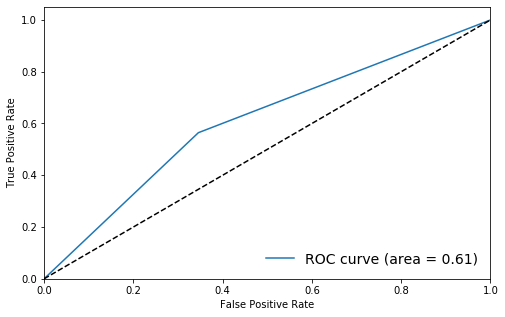

In [63]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

## Naive Bayes with SMOTE

In [59]:
sm = SMOTE(random_state=42)

In [60]:
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({0: 33785, 1: 4670})


In [92]:
X_train_res_smote, y_train_res_smote = sm.fit_resample(X_train, y_train)

In [93]:
print('Resampled dataset shape %s' % Counter(y_train_res_smote))

Resampled dataset shape Counter({0: 33785, 1: 33785})


In [65]:
gnb2 = GaussianNB()

In [94]:
gnb2.fit(X_train_res_smote, y_train_res_smote)

GaussianNB(priors=None, var_smoothing=1e-09)

In [103]:
%%timeit -n 1
gnb2.predict(X_val)

28.1 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
#y_pred_over della cella precedente non viene salvato
y_pred_smote = gnb2.predict(X_val)

In [97]:
print("Number of mislabeled points out of a total %d points : %d" % (X_val.shape[0], (y_val != y_pred_smote).sum()))

Number of mislabeled points out of a total 16482 points : 7631


46,3% di misclassified

## Naive Bayes with oversampling

In [90]:
ros = RandomOverSampler(random_state=42)

In [91]:
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({0: 33785, 1: 4670})


In [98]:
X_train_res_over, y_train_res_over = ros.fit_resample(X_train, y_train)

In [99]:
print('Resampled dataset shape %s' % Counter(y_train_res_over))

Resampled dataset shape Counter({0: 33785, 1: 33785})


In [102]:
%%timeit -n 1
gnb2.predict(X_val)

25.5 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
y_pred_over = gnb2.predict(X_val)

In [107]:
print("Number of mislabeled points out of a total %d points : %d" % (X_val.shape[0], (y_val != y_pred_over).sum()))

Number of mislabeled points out of a total 16482 points : 7631


46,3% di misclassified

# Random Forest

Ho visto che Random Forest non è richiesta.

## Gridsearch

In [119]:
param_list = {'n_estimators': list(np.arange(2, 100)),
              'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(np.arange(2, 100)),
              'min_samples_split': list(np.arange(2, 100)),
              'min_samples_leaf': list(np.arange(1, 100)),
             }
new_params = {'randomforestclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = RandomForestClassifier(n_estimators=2, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
imba_pipeline = make_pipeline(RandomUnderSampler(), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

random_search = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=1000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)
random_search.fit(X_train, y_train)
cnfs = report_multiple(random_search.cv_results_, n_top=3, scoring = 'roc_auc')

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed: 11.2min finished


Model with rank: 1
Mean training score:   roc_auc: 0.741 (std: 0.006), Accuracy: 0.639 (std: 0.009), f1: 0.324 (std: 0.005)
Mean validation score: roc_auc: 0.686 (std: 0.004), Accuracy: 0.620 (std: 0.008), f1: 0.289 (std: 0.003)
Parameters: {'randomforestclassifier__n_estimators': 89, 'randomforestclassifier__min_samples_split': 99, 'randomforestclassifier__min_samples_leaf': 7, 'randomforestclassifier__max_depth': 28, 'randomforestclassifier__criterion': 'entropy'}

Model with rank: 2
Mean training score:   roc_auc: 0.822 (std: 0.001), Accuracy: 0.665 (std: 0.004), f1: 0.375 (std: 0.002)
Mean validation score: roc_auc: 0.686 (std: 0.002), Accuracy: 0.619 (std: 0.002), f1: 0.288 (std: 0.002)
Parameters: {'randomforestclassifier__n_estimators': 87, 'randomforestclassifier__min_samples_split': 23, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 59, 'randomforestclassifier__criterion': 'gini'}

Model with rank: 3
Mean training score:   roc_auc: 0.752 (s

## Perform Classification

In [120]:
models_u = []
y_pred_vals_u = []
y_pred_trains_u = []
hyper_ps = random_search.cv_results_
for cnf in cnfs.values():
    n_estimators = cnf['randomforestclassifier__n_estimators']
    criterion = cnf['randomforestclassifier__criterion']
    max_depth = cnf['randomforestclassifier__max_depth']
    min_samples_split = cnf['randomforestclassifier__min_samples_split']
    min_samples_leaf = cnf['randomforestclassifier__min_samples_leaf']
    clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(X_train_res, y_train_res)
    models_u.append(clf)
    y_pred = clf.predict(X_val)
    y_pred_tr = clf.predict(X_train_res)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr) 

## Analyze the classification results

In [121]:
for i in range(0,len(cnfs)):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_train_res, y_pred_trains_u[i]))
    print('Train F1-score %s' % f1_score(y_train_res, y_pred_trains_u[i], average=None))
    print()

    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals_u[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals_u[i], average=None))
    print(classification_report(y_val, y_pred_vals_u[i]))
    print(confusion_matrix(y_val, y_pred_vals_u[i]))

model 0
Train Accuracy 0.6986081370449678
Train F1-score [0.69150685 0.70538985]

Test Accuracy 0.616672733891518
Test F1-score [0.73675    0.29518072]
              precision    recall  f1-score   support

           0       0.93      0.61      0.74     14480
           1       0.19      0.66      0.30      2002

    accuracy                           0.62     16482
   macro avg       0.56      0.64      0.52     16482
weighted avg       0.84      0.62      0.68     16482

[[8841 5639]
 [ 679 1323]]
model 1
Train Accuracy 0.8220556745182013
Train F1-score [0.82171208 0.82239795]

Test Accuracy 0.6235286979735469
Test F1-score [0.74224235 0.30210325]
              precision    recall  f1-score   support

           0       0.93      0.62      0.74     14480
           1       0.19      0.67      0.30      2002

    accuracy                           0.62     16482
   macro avg       0.56      0.64      0.52     16482
weighted avg       0.84      0.62      0.69     16482

[[8934 5546]
 

In [124]:
roc_auc_models_u = []
for i in range(0,len(cnfs)):
    fpr, tpr, _ = roc_curve(y_train_res, y_pred_trains_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_train_res, y_pred_trains_u[i], average=None)
    print("model {} - roc_auc: {}".format(i, roc_auc))
    roc_auc_models_u.append(roc_auc)

model 0 - roc_auc: 0.6986081370449679
model 1 - roc_auc: 0.8220556745182013
model 2 - roc_auc: 0.7211991434689506


In [123]:
roc_auc_models_u = []
for i in range(0,len(cnfs)):
    fpr, tpr, _ = roc_curve(y_val, y_pred_vals_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals_u[i], average=None)
    print("model {} - roc_auc: {}".format(i, roc_auc))
    roc_auc_models_u.append(roc_auc)

model 0 - roc_auc: 0.6357027295908513
model 1 - roc_auc: 0.6439090605527069
model 2 - roc_auc: 0.6403717829132193


## Choose the best model

<p>Come miglior modello scelgo il model 2, essendo quello con la ROC AUC migliore.</p>
<p>{'randomforestclassifier__n_estimators': 87, 'randomforestclassifier__min_samples_split': 23, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 59, 'randomforestclassifier__criterion': 'gini'}</p>

In [44]:
clf = RandomForestClassifier(n_estimators=87, criterion='gini', max_depth=59, min_samples_split=23, min_samples_leaf=3)

In [45]:
%%timeit -n 1
clf.fit(X_train_res, y_train_res)

1.93 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit -n 1
clf.predict(X_val)

456 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
y_pred = clf.predict(X_val)

In [48]:
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, y_pred, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))

model 0 - roc_auc: 0.6357771372274135


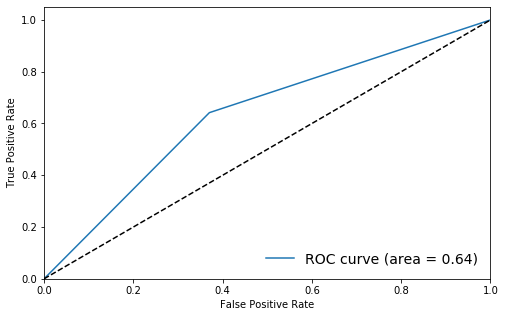

In [49]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

#### Features importance

In [166]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

VehicleAge 0.23629000665300234
VehOdo 0.08768061238713067
MMRAcquisitionAuctionAveragePrice 0.09032849222069696
MMRAcquisitionRetailAveragePrice 0.07314219766374157
MMRCurrentAuctionAveragePrice 0.10551033716995357
MMRCurrentRetailAveragePrice 0.08155927294140719
VehBCost 0.09927127065991694
WarrantyCost 0.05596965036507156
Auction_ADESA 0.010961482638368594
Auction_MANHEIM 0.009142126858512477
Auction_OTHER 0.005169864164908748
Size_COMPACT 0.004572361083264975
Size_CROSSOVER 0.002317497793446041
Size_LARGE 0.009412416056380778
Size_LARGE SUV 0.002311776134264732
Size_LARGE TRUCK 0.0024187636579882234
Size_MEDIUM 0.011250596663636602
Size_MEDIUM SUV 0.010332346929276384
Size_SMALL SUV 0.0029889675873456738
Size_SMALL TRUCK 0.0007885737427601482
Size_SPECIALTY 0.0014641218732117578
Size_SPORTS 0.000890285566228913
Size_VAN 0.003281124013469411
VNST_AL 0.0007293266762241333
VNST_AR 0.0
VNST_AZ 0.0049013165539991835
VNST_CA 0.004550557798907594
VNST_CO 0.006458492513456036
VNST_FL 0.0070

In [19]:
importances = clf.feature_importances_

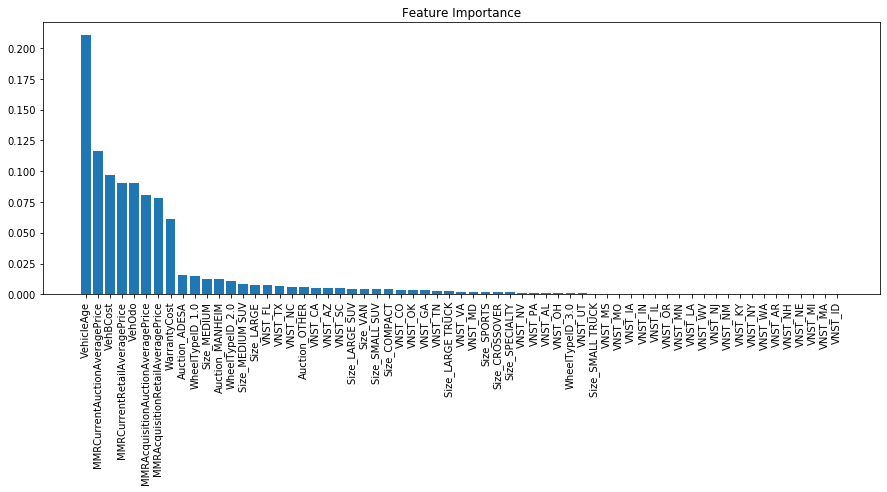

In [34]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

df1 = df
del df1['IsBadBuy']

# Rearrange feature names so they match the sorted feature importances
names = [df1.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(15, 5))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

# K-NN

## Gridsearch

In [134]:
param_list = {'n_neighbors': list(np.arange(2, 200)),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto'],
              'leaf_size': list(np.arange(2, 200)),
             }
new_params = {'kneighborsclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='auto', leaf_size=2)
imba_pipeline = make_pipeline(RandomUnderSampler(), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

random_search = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=1000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)
random_search.fit(X_train, y_train)
cnfs = report_multiple(random_search.cv_results_, n_top=3, scoring = 'roc_auc')

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 23.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 42.2min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 66.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 95.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 129.6min


Model with rank: 1
Mean training score:   roc_auc: 1.000 (std: 0.000), Accuracy: 0.710 (std: 0.009), f1: 0.456 (std: 0.008)
Mean validation score: roc_auc: 0.643 (std: 0.008), Accuracy: 0.614 (std: 0.007), f1: 0.268 (std: 0.004)
Parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 135, 'kneighborsclassifier__leaf_size': 142, 'kneighborsclassifier__algorithm': 'auto'}

Model with rank: 2
Mean training score:   roc_auc: 1.000 (std: 0.000), Accuracy: 0.700 (std: 0.011), f1: 0.447 (std: 0.009)
Mean validation score: roc_auc: 0.643 (std: 0.008), Accuracy: 0.602 (std: 0.006), f1: 0.267 (std: 0.003)
Parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 131, 'kneighborsclassifier__leaf_size': 193, 'kneighborsclassifier__algorithm': 'auto'}

Model with rank: 3
Mean training score:   roc_auc: 1.000 (std: 0.000), Accuracy: 0.692 (std: 0.013), f1: 0.441 (std: 0.010)
Mean validation score: roc_auc: 0.642 (std: 0.007)

[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed: 158.5min finished


Non capisco se è andato in overfitting o no. Lo provo sul validation esterno e dopo provo un'altra grid.

## Perform Classification

In [135]:
models_u = []
y_pred_vals_u = []
y_pred_trains_u = []
hyper_ps = random_search.cv_results_
for cnf in cnfs.values():
    n_neighbors = cnf['kneighborsclassifier__n_neighbors']
    weights = cnf['kneighborsclassifier__weights']
    algorithm = cnf['kneighborsclassifier__algorithm']
    leaf_size = cnf['kneighborsclassifier__leaf_size']
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size)
    clf = clf.fit(X_train_res, y_train_res)
    models_u.append(clf)
    y_pred = clf.predict(X_val)
    y_pred_tr = clf.predict(X_train_res)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr) 

## Analyze the classification results

In [136]:
for i in range(0,len(cnfs)):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_train_res, y_pred_trains_u[i]))
    print('Train F1-score %s' % f1_score(y_train_res, y_pred_trains_u[i], average=None))
    print()

    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals_u[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals_u[i], average=None))
    print(classification_report(y_val, y_pred_vals_u[i]))
    print(confusion_matrix(y_val, y_pred_vals_u[i]))

model 0
Train Accuracy 1.0
Train F1-score [1. 1.]

Test Accuracy 0.5939206406989443
Test F1-score [0.71808264 0.27431421]
              precision    recall  f1-score   support

           0       0.92      0.59      0.72     14480
           1       0.18      0.63      0.27      2002

    accuracy                           0.59     16482
   macro avg       0.55      0.61      0.50     16482
weighted avg       0.83      0.59      0.66     16482

[[8524 5956]
 [ 737 1265]]
model 1
Train Accuracy 1.0
Train F1-score [1. 1.]

Test Accuracy 0.5917364397524573
Test F1-score [0.71606397 0.27371829]
              precision    recall  f1-score   support

           0       0.92      0.59      0.72     14480
           1       0.17      0.63      0.27      2002

    accuracy                           0.59     16482
   macro avg       0.55      0.61      0.49     16482
weighted avg       0.83      0.59      0.66     16482

[[8485 5995]
 [ 734 1268]]
model 2
Train Accuracy 1.0
Train F1-score [1. 1.

In [137]:
roc_auc_models_u = []
for i in range(0,len(cnfs)):
    fpr, tpr, _ = roc_curve(y_train_res, y_pred_trains_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_train_res, y_pred_trains_u[i], average=None)
    print("model {} - roc_auc: {}".format(i, roc_auc))
    roc_auc_models_u.append(roc_auc)

model 0 - roc_auc: 1.0
model 1 - roc_auc: 1.0
model 2 - roc_auc: 1.0


In [138]:
roc_auc_models_u = []
for i in range(0,len(cnfs)):
    fpr, tpr, _ = roc_curve(y_val, y_pred_vals_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals_u[i], average=None)
    print("model {} - roc_auc: {}".format(i, roc_auc))
    roc_auc_models_u.append(roc_auc)

model 0 - roc_auc: 0.6102710825086516
model 1 - roc_auc: 0.6096736481750294
model 2 - roc_auc: 0.6075214495449303


## Choose the best model

<p>Il modello migliore sembrerebbe il model 0, anche se probabilmente è in overfitting.<p>
<p>{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 135, 'kneighborsclassifier__leaf_size': 142, 'kneighborsclassifier__algorithm': 'auto'}</p>

In [173]:
neigh = KNeighborsClassifier(n_neighbors=135, weights='distance', algorithm='auto', leaf_size=142)

In [174]:
%%timeit -n 1
neigh.fit(X_train_res, y_train_res)

79.4 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [175]:
neigh.fit(X_train_res, y_train_res)

KNeighborsClassifier(algorithm='auto', leaf_size=142, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=135, p=2,
                     weights='distance')

In [176]:
%%timeit -n 1
neigh.predict(X_val)

1.8 s ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [177]:
y_pred = neigh.predict(X_val)

In [178]:
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, y_pred, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))

model 0 - roc_auc: 0.6102710825086516


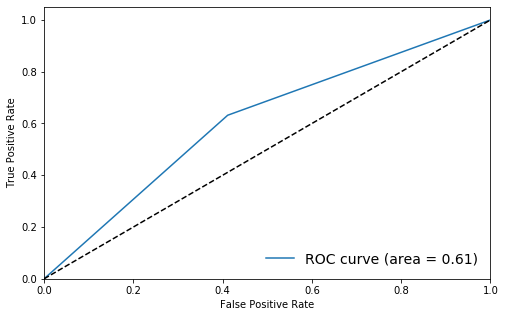

In [179]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# Another gridsearch

In [148]:
param_list = {'n_neighbors': [200, 300, 400, 500, 600, 700, 800, 1000],
              'weights': ['distance'],
              'algorithm': ['auto'],
              'leaf_size': [100, 130, 160, 190, 220],
             }
new_params = {'kneighborsclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = KNeighborsClassifier(n_neighbors=200, weights='distance', algorithm='auto', leaf_size=100)
imba_pipeline = make_pipeline(RandomUnderSampler(), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

random_search = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=1000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)
random_search.fit(X_train, y_train)
cnfs = report_multiple(random_search.cv_results_, n_top=3, scoring = 'roc_auc')

C:\Users\Giulia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 40 is smaller than n_iter=1000. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.5min


Model with rank: 1
Mean training score:   roc_auc: 1.000 (std: 0.000), Accuracy: 0.704 (std: 0.016), f1: 0.451 (std: 0.013)
Mean validation score: roc_auc: 0.641 (std: 0.008), Accuracy: 0.609 (std: 0.017), f1: 0.266 (std: 0.004)
Parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 200, 'kneighborsclassifier__leaf_size': 100, 'kneighborsclassifier__algorithm': 'auto'}

Model with rank: 2
Mean training score:   roc_auc: 1.000 (std: 0.000), Accuracy: 0.714 (std: 0.012), f1: 0.459 (std: 0.010)
Mean validation score: roc_auc: 0.641 (std: 0.008), Accuracy: 0.619 (std: 0.012), f1: 0.267 (std: 0.004)
Parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 200, 'kneighborsclassifier__leaf_size': 160, 'kneighborsclassifier__algorithm': 'auto'}

Model with rank: 3
Mean training score:   roc_auc: 1.000 (std: 0.000), Accuracy: 0.694 (std: 0.005), f1: 0.442 (std: 0.004)
Mean validation score: roc_auc: 0.640 (std: 0.007)

[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 16.5min finished


## Other tests

In [193]:
neigh = KNeighborsClassifier(n_neighbors=9000, weights='distance', algorithm='auto', leaf_size=150)
neigh.fit(X_train_res, y_train_res)
y_pred = neigh.predict(X_val)
y_pred_train = neigh.predict(X_train_res)

fpr, tpr, _ = roc_curve(y_train_res, y_pred_train)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_train_res, y_pred_train, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))

fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, y_pred, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))

model 0 - roc_auc: 1.0
model 0 - roc_auc: 0.5910739812673513


<p>Ho aumentato gradualmente il numero di vicini per cercare di migliorare la roc sul validation e di peggiorare quella sul training, ma niente.</p>

## Choose the final best model

<p>Prendo quello selezionato dopo la prima gridsearch</p>

In [180]:
neigh = KNeighborsClassifier(n_neighbors=135, weights='distance', algorithm='auto', leaf_size=142)

In [181]:
%%timeit -n 1
neigh.fit(X_train_res, y_train_res)

81 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [182]:
neigh.fit(X_train_res, y_train_res)

KNeighborsClassifier(algorithm='auto', leaf_size=142, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=135, p=2,
                     weights='distance')

In [183]:
%%timeit -n 1
neigh.predict(X_val)

1.87 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [160]:
y_pred = neigh.predict(X_val)

In [161]:
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, y_pred, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))

model 0 - roc_auc: 0.6102710825086516


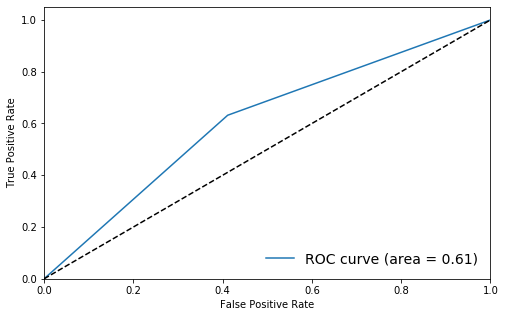

In [162]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# Decision Tree

In [10]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=26, min_samples_leaf=25)

In [11]:
%%timeit -n 1
dtc.fit(X_train_res, y_train_res)

33.8 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
dtc.fit(X_train_res, y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=26,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
%%timeit -n 1
dtc.predict(X_val)

4.74 ms ± 947 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
y_pred = dtc.predict(X_val)

In [16]:
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, y_pred, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))

model 0 - roc_auc: 0.6072163333903666


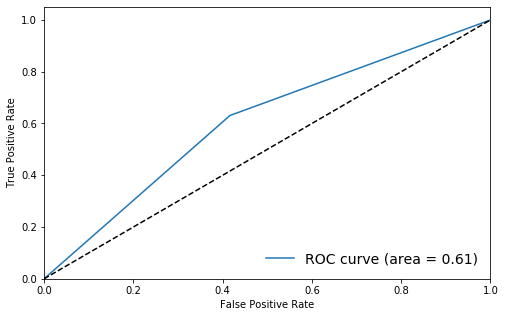

In [17]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()